# This notebook takes an area of interest (Tampa Bay, FL), queries the Water Quality Portal, removes unwanted points and saves a geoJSON (or shapefile) with points and temperatures

In [1]:
# Import all the required libraries
import os
from io import BytesIO
from zipfile import ZipFile
import requests
import pandas
import numpy
import geopandas
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# All notebook functions
def response_zip_to_df(res):
    """Returns dataframe from zipped csv response
    Note: This can be memory intensive for large results, specify dtypes for read_csv to reduce
    """
    # zipfile object from response content bytes
    archive = ZipFile(BytesIO(res.content))
    item1 = archive.namelist()[0]  # Name of first file
    return pandas.read_csv(archive.open(item1), low_memory=False)


def getBoundingBox(shp):
    """Use geopandas library instead of arcpy
    param@fc should be a shapefile
    """
    if not isinstance(shp, geopandas.geodataframe.GeoDataFrame):
        shp = geopandas.read_file(shp)
    xmin = shp.bounds['minx'][0]
    xmax = shp.bounds['maxx'][0]
    ymin = shp.bounds['miny'][0]
    ymax = shp.bounds['maxy'][0]

    return ','.join(map(str, [xmin, ymin, xmax, ymax]))


def req_str(url, data):
    """Use requests lib to print url server request"""
    return requests.Request('GET', url, params=data).prepare().url


def getWQP(params):
    """Doc string..."""

    # Copy dict to avoid in-place changes
    data = params

    # Pull dataTable from data
    if 'dataTable' in data.keys():
        table = data['dataTable']
        del data['dataTable']
    else:
        table = 'Station'

    # Standard Params
    data['mimeType'] = 'csv'
    data['zip'] = 'yes'

    # Source url
    url = "https://www.waterqualitydata.us/data/{}/search".format(table)

    # Check url status
    if requests.get(url).status_code != 200:
        statusCode = requests.get(url).status_code
        print("{} web service response {}".format(url, statusCode))
    res = requests.get(url, data)
    if not res.ok:
        print("Problem with response from {}".format(req_str(url, data)))
        print(res.headers['Warning'], 1)
        # add break?

    return res


def station_df_to_gdf(df, outEPSG=4269):
    """Params station DataFrame, desired EPSG code
    Returns simplified geodataframe with consistent datum matching EPSG
    Assumes unrecognized or missing crs datum column names are already in outEPSG
    """
    # Dictionary of expected crs
    crsdict = {'NAD27': 4267, 'NAD83': 4269, 'WGS84': 4326, }

    # Filter columns for simplified dataframe
    latCol, lonCol = 'LatitudeMeasure', 'LongitudeMeasure'
    crsCol = 'HorizontalCoordinateReferenceSystemDatumName'
    cols = ['OrganizationIdentifier', 'OrganizationFormalName',
            'MonitoringLocationIdentifier', 'MonitoringLocationTypeName',
            'ProviderName', latCol, lonCol, crsCol]
    df = df.filter(items=cols)

    # Create geodataframe for each station crs
    gdf_list = []
    for crs in set(df[crsCol]):
        sub_df = df[df[crsCol] == crs]  #df subset w/ CRS
        # Create sub-geodataframe
        geom = geopandas.points_from_xy(sub_df[lonCol], sub_df[latCol])
        sub_gdf = geopandas.GeoDataFrame(sub_df, geometry=geom)

        # Set CRS for sub-geodataframe
        if crs in crsdict.keys():
            sub_gdf.set_crs(epsg=crsdict[crs], inplace=True)
            # Transform if necessary
            if crsdict[crs] != outEPSG:
                sub_gdf.to_crs(outEPSG, inplace=True)
        else:
            sub_gdf.set_crs(epsg=outEPSG, inplace=True)

        gdf_list.append(sub_gdf)

    # Assert CRS all match outEPSG (should always)
    for gdf in gdf_list:
        assert gdf.crs.to_epsg() == outEPSG, "Projections don't match"

    if len(gdf_list) > 1:
        # Recombine sub geodataframes
        gdf = geopandas.GeoDataFrame(pandas.concat(gdf_list,
                                                   ignore_index=True))
    else:
        gdf = gdf_list[0]
    # Drop old fields (this could be made optional)
    gdf.drop(columns=[latCol, lonCol, crsCol], inplace=True)

    return gdf


def datetime_combine(df, date_field, time_field, tz_field, datetime_field):
    """from USGS data retrieval (for NWIS)"""
    # Time zone converter dictionary
    tz_dict = {'EST': '-0500',
               'EDT': '-0400',
               numpy.nan: ''}
    df[tz_field] = df[tz_field].map(tz_dict)
    df[time_field] = df[time_field].fillna('00:00:00')

    # datetime formated
    df[datetime_field] = pandas.to_datetime(df.pop(date_field) + ' ' +
                                            df.pop(time_field) + ' ' +
                                            df.pop(tz_field),
                                            format='%Y-%m-%d %H:%M',
                                            utc=True)
    return df


def temp_F_to_C(temp_F):
    """Convert temperture from Fahrenheit to Celsius"""
    return (temp_F - 32.0) * 5.0 / 9.0


def convert_temperature(df, val_field, unit_field, new_field):
    """Convert temperature field to consistent degrees C
    if new_field specified (default) dataframe updated inplace and old fields dropped
    if no new_field specified returns series with converted values
    """
    #val_field dtype should be 'float64', otherwise non-floats -> NaN
    if df[val_field].dtype != numpy.float64:
        df[val_field] = pandas.to_numeric(df[val_field],
                                          downcast="float",
                                          errors='coerce')
    unit_mask = df[unit_field] == 'deg F'
    df[new_field] = df[val_field].mask(unit_mask, temp_F_to_C(df[val_field]))
    df.drop([val_field, unit_field], axis=1, inplace=True)
    # If no new field
    # df[val_field].mask(unit_mask, temp_F_to_C(df[val_field]))

## Part 1: Retrieve Data

Load Area of Interest (AOI) shapefile from temperature_data folder in current working directory.

In [3]:
data_dir = os.path.join(os.getcwd(), 'temperature_data')
# Original source:
shp_aoi = os.path.join(data_dir, 'TampaBay.shp')
gdf_aoi = geopandas.read_file(shp_aoi)

Build WQP query for water temperature

In [4]:
query = {'characteristicName': 'Temperature, water'}
# CRS for WQP Datum must be NAD83 and linear unit decimal degrees
#curent = 4269, query =? NAD83, assert gdf_aoi.crs.datum?
# Optional start date. There are earlier data points we excluded
query['startDateLo'] = '01-01-1995'
# Bounding box
query['bBox'] = getBoundingBox(gdf_aoi)

Run query and create geodataframe from query response

In [5]:
response = getWQP(query)
station_df = response_zip_to_df(response)

https://www.waterqualitydata.us/data/Station/search web service response 400


In [6]:
stations_gdf = station_df_to_gdf(station_df)
print('Number of stations in extent: {}'.format(len(stations_gdf)))

Number of stations in extent: 12381


Clip geodataframe to original Area Of Interest (AOI)

In [7]:
# Change Coordinate Reference System to match AOI if it doesn't already
if stations_gdf.crs != gdf_aoi.crs:
    stations_gdf.to_crs(gdf_aoi.crs.to_epsg(), inplace=True)
# Sample points are retrieved by extent, so clip it to the AOI
stations_aoi_gdf = geopandas.clip(stations_gdf, gdf_aoi)
print('Number of stations in AOI: {}'.format(len(stations_aoi_gdf)))

Number of stations in AOI: 9041


Run query for results and create dataframe from response

In [8]:
query['dataTable'] = 'Result'
query['dataProfile'] = 'narrowResult'

In [9]:
# This is a big request and may be slow
response = getWQP(query)

https://www.waterqualitydata.us/data/Result/search web service response 400


In [10]:
results_df = response_zip_to_df(response)

Drop empty and duplicate fields from dataframe

In [11]:
results_df.dropna(axis=1, how='all', inplace=True)
results_df.drop(columns=['OrganizationIdentifier',
                         'OrganizationFormalName',
                         'ProviderName'],
                inplace=True)

In [12]:
print('Number of temperature results in extent: {}'.format(len(results_df)))

Number of temperature results in extent: 249771


Join station points and temperature results on 'MonitoringLocationIdentifier'

In [13]:
loc_ID = 'MonitoringLocationIdentifier'
results_gdf = stations_aoi_gdf.set_index(loc_ID).join(results_df.set_index(loc_ID))
# Note: should match number of stations in AOI
print('Sample sites with results in AOI: {}'.format(len(set(results_gdf.index))))

Sample sites with results in AOI: 9041


In [14]:
print('Number of temperature results in AOI: {}'.format(len(results_gdf)))

Number of temperature results in AOI: 193664


Convert temperature results to consistent units

In [15]:
results_gdf['ResultMeasureValue'].dtype == numpy.float64

False

In [16]:
convert_temperature(results_gdf,
                    'ResultMeasureValue',
                    'ResultMeasure/MeasureUnitCode',
                    'deg_c')
results_gdf.reset_index(inplace=True)

## Part 2: Drop unwanted results

Drop NaN and outliers (>100 C)

In [17]:
# Create dataframe of outliers to inspect
outliers = results_gdf[results_gdf['deg_c'] >= 100]
# Count NaNs
null_results = results_gdf[results_gdf['deg_c'].isnull()]
# Drop outliers from results data frame (also drops NaN)
clean_gdf = results_gdf[results_gdf['deg_c'] < 100]
# Display dropped 
outliers.head()

,MonitoringLocationIdentifier,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationTypeName,ProviderName,geometry,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,...,ResultAnalyticalMethod/MethodIdentifier,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,AnalysisStartTime/Time,AnalysisStartTime/TimeZoneCode,ResultDetectionQuantitationLimitUrl,deg_c
142246,21FLSWFD_WQX-709064,21FLSWFD_WQX,Southwest Florida Water Management District,Estuary,STORET,POINT (-82.47788 27.75709),21FLSWFD_WQX-0722081350FX,2008-07-22,13:01:00,EDT,...,170.1,USEPA,Temperature,https://www.nemi.gov/methods/method_summary/5216/,NaN,2008-07-22,0001-01-01 13:01:00,EST,NaN,43696.0


In [18]:
print('Removed {} nulls and {} outliers'
      .format(len(null_results), len(outliers)))

Removed 1 nulls and 1 outliers


Identify and drop any temperature from a depth >=5 m

In [19]:
# All units are currently in m (new data may require conversion)
depth_col = 'ResultDepthHeightMeasure/MeasureValue'
non_surface = results_gdf[results_gdf[depth_col] >= 5]
# Drop non-surface results from results data frame
clean_gdf = clean_gdf[~(clean_gdf[depth_col] >= 5)]
# Display dropped
non_surface.head()

,MonitoringLocationIdentifier,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationTypeName,ProviderName,geometry,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,...,ResultAnalyticalMethod/MethodIdentifier,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,AnalysisStartTime/Time,AnalysisStartTime/TimeZoneCode,ResultDetectionQuantitationLimitUrl,deg_c


In [20]:
print('{} non-surface results'.format(len(non_surface)))

0 non-surface results


Identify and drop duplicate temperatures at the same location and time

In [21]:
# Create dataframe of duplicate temperatures at the same location and time
# Total 205,207 vs duplicates 27,816 = ~13.6% -> w/ loc_id 27,756 = ~13.5% ()
duplicates = clean_gdf[clean_gdf[['geometry',
                                  'ActivityStartDate',
                                  'ActivityStartTime/Time',
                                  'deg_c']]
                         .duplicated(keep=False)].sort_values(by=['deg_c'])
print('Number of duplicates (all copies): {}'.format(len(duplicates)))

Number of duplicates (all copies): 35535


Only the first result of a duplicate result pair was retained. Further analysis of duplicates could help identify the higher quality result (e.g. multiple readings using different methods) or the underlying cause of those duplicates (e.g. an update/error in location ID, the same data loaded by multiple organozations, etc.).

In [22]:
# dup_group = duplicates.groupby(['ActivityStartDate',
#                                'ActivityStartTime/Time',
#                                'deg_c'])

In [23]:
#dup_group['MonitoringLocationIdentifier'].mask(dup_group['MonitoringLocationIdentifier'].nunique()==6)

In [24]:
new_duplicates = duplicates.set_index(['ActivityStartDate',
                                       'ActivityStartTime/Time',
                                       'deg_c'])

In [25]:
new_duplicates.head()

MonitoringLocationIdentifier  \
ActivityStartDate ActivityStartTime/Time deg_c                                
2010-01-12        10:01:00               8.60        21FLSEAS_WQX-48SEAS050   
                                         8.60        21FLSEAS_WQX-48SEAS050   
                  13:01:00               8.90        21FLSEAS_WQX-48SEAS290   
                                         8.90        21FLSEAS_WQX-48SEAS290   
2010-12-15        12:01:00               8.91              21FLHILL_WQX-180   

                                               OrganizationIdentifier  \
ActivityStartDate ActivityStartTime/Time deg_c                          
2010-01-12        10:01:00               8.60            21FLSEAS_WQX   
                                         8.60            21FLSEAS_WQX   
                  13:01:00               8.90            21FLSEAS_WQX   
                                         8.90            21FLSEAS_WQX   
2010-12-15        12:01:00               8.91            21FLHILL_WQX   

                                                                           OrganizationFormalName  \
ActivityStartDate ActivityStartTime/Time deg_c                                                      
2010-01-12        10:01:00               8.60      Florida Department of Environmental Protection   
                                         8.60      Florida Department of Environmental Protection   
                  13:01:00               8.90      Florida Department of Environmental Protection   
                                         8.90      Florida Department of Environmental Protection   
2010-12-15        12:01:00               8.91   Environmental Protection Commission of Hillsbo...   

                                               MonitoringLocationTypeName  \
ActivityStartDate ActivityStartTime/Time deg_c                              
2010-01-12        10:01:00               8.60                     Estuary   
                                         8.60                     Estuary   
                  13:01:00               8.90                     Estuary   
                                         8.90                     Estuary   
2010-12-15        12:01:00               8.91                     Estuary   

                                               ProviderName  \
ActivityStartDate ActivityStartTime/Time deg_c                
2010-01-12        10:01:00               8.60        STORET   
                                         8.60        STORET   
                  13:01:00               8.90        STORET   
                                         8.90        STORET   
2010-12-15        12:01:00               8.91        STORET   

                                                                  geometry  \
ActivityStartDate ActivityStartTime/Time deg_c                               
2010-01-12        10:01:00               8.60   POINT (-82.70400 27.52983)   
                                         8.60   POINT (-82.70400 27.52983)   
                  13:01:00               8.90   POINT (-82.64133 27.53533)   
                                         8.90   POINT (-82.64133 27.53533)   
2010-12-15        12:01:00               8.91   POINT (-82.47044 27.71599)   

                                                       ActivityIdentifier  \
ActivityStartDate ActivityStartTime/Time deg_c                              
2010-01-12        10:01:00               8.60   21FLSEAS_WQX-480500112103   
                                         8.60   21FLSEAS_WQX-480500112104   
                  13:01:00               8.90   21FLSEAS_WQX-482900112104   
                                         8.90   21FLSEAS_WQX-482900112103   
2010-12-15        12:01:00               8.91    21FLHILL_WQX-101215180-B   

                                               ActivityStartTime/TimeZoneCode  \
ActivityStartDate ActivityStartTime/Time deg_c                                  
2010-01-12        10:01:00               8

In [26]:
# Look at duplicates with subset of fields
#TODO: clever way to limit to diferences in each pair?
cols = duplicates.columns.difference(['geometry'])
drop_cols = [col for col in cols if len(set(duplicates[col]))<2]
duplicates.drop(drop_cols, axis=1).head()

,MonitoringLocationIdentifier,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationTypeName,geometry,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,ResultIdentifier,...,ResultAnalyticalMethod/MethodIdentifier,ResultAnalyticalMethod/MethodIdentifierContext,ResultAnalyticalMethod/MethodName,MethodDescriptionText,LaboratoryName,AnalysisStartDate,AnalysisStartTime/Time,AnalysisStartTime/TimeZoneCode,ResultDetectionQuantitationLimitUrl,deg_c
139322,21FLSEAS_WQX-48SEAS050,21FLSEAS_WQX,Florida Department of Environmental Protection,Estuary,POINT (-82.70400 27.52983),21FLSEAS_WQX-480500112103,2010-01-12,10:01:00,EST,STORET-311703532,...,2550,APHA,Temperature of Water by Thermometer,NaN,NaN,2010-01-13,0001-01-01 12:01:00,EST,NaN,8.60
139308,21FLSEAS_WQX-48SEAS050,21FLSEAS_WQX,Florida Department of Environmental Protection,Estuary,POINT (-82.70400 27.52983),21FLSEAS_WQX-480500112104,2010-01-12,10:01:00,EST,STORET-311602068,...,2550,APHA,Temperature of Water by Thermometer,NaN,NaN,2010-01-13,0001-01-01 12:01:00,EST,NaN,8.60
141036,21FLSEAS_WQX-48SEAS290,21FLSEAS_WQX,Florida Department of Environmental Protection,Estuary,POINT (-82.64133 27.53533),21FLSEAS_WQX-482900112104,2010-01-12,13:01:00,EST,STORET-311655098,...,2550,APHA,Temperature of Water by Thermometer,NaN,NaN,2010-01-13,0001-01-01 12:01:00,EST,NaN,8.90
141040,21FLSEAS_WQX-48SEAS290,21FLSEAS_WQX,Florida Department of Environmental Protection,Estuary,POINT (-82.64133 27.53533),21FLSEAS_WQX-482900112103,2010-01-12,13:01:00,EST,STORET-311699263,...,2550,APHA,Temperature of Water by Thermometer,NaN,NaN,2010-01-13,0001-01-01 12:01:00,EST,NaN,8.90
95107,21FLHILL_WQX-180,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,Estuary,POINT (-82.47044 27.71599),21FLHILL_WQX-101215180-B,2010-12-15,12:01:00,EST,STORET-300569297,...,FT 1400,21FLHILL_WQX,Field Measurement of Temperature,NaN,NaN,2001-01-01,0001-01-01 00:01:00,EST,NaN,8.91


In [27]:
# Ultimately we choose to drop duplicates even if they had different loc_ID
# (n=12, or six pairs of loc_ID where a geometry&time&value matched)
duplicates2 = clean_gdf[clean_gdf[['geometry',
                                 loc_ID,
                                 'ActivityStartDate',
                                 'ActivityStartTime/Time',
                                 'deg_c']]
                    .duplicated(keep=False)].sort_values(by=['deg_c'])
df_all = duplicates.merge(duplicates2,  
                   how='left', indicator=True)
# Duplicates w/ non-matching loc_ID (12 loc_IDs)
loc_ID_mismatch = df_all[df_all['_merge'] == 'left_only']
unique = set(loc_ID_mismatch[loc_ID])
print('{} duplicates with the same {}'
      .format(len(duplicates) - len(duplicates2), loc_ID))

21 duplicates with the same MonitoringLocationIdentifier


In [28]:
for loc in unique:
    dups = len(duplicates[duplicates[loc_ID] == loc])
    results = len(clean_gdf[clean_gdf[loc_ID] == loc])
    print('{} duplicates of {} results at {}'.format(dups, results, loc))

142 duplicates of 616 results at 21FLBSG-170
158 duplicates of 1060 results at 21FLBSG-17


In [29]:
for org in set(duplicates.OrganizationFormalName):
    print('{}: {} duplicates of {} results'
          .format(org,
                  len(duplicates[duplicates.OrganizationFormalName == org]),
                  len(clean_gdf[clean_gdf.OrganizationFormalName == org]),
                 ))

Environmental Protection Commission of Hillsborough County: 22722 duplicates of 80803 results
EPA National Aquatic Resources Survey (NARS): 2 duplicates of 5 results
Florida Fish & Wildlife C C / Marine Research Institute: 73 duplicates of 134 results
Pinellas County Dept. of Environmental Management: 1129 duplicates of 8885 results
Southwest Florida Water Management District: 194 duplicates of 1136 results
Environmental Monitoring and Assessment Program: 22 duplicates of 28 results
City of Tampa Bay Study Group (Florida): 2999 duplicates of 24455 results
Tampa Bay Water: 440 duplicates of 23308 results
City of St Petersburg: 20 duplicates of 462 results
FL Dept. Environmental Protection, Southwest District: 26 duplicates of 489 results
Pinellas County Dept. of Environmental Management (Florida): 56 duplicates of 8315 results
Manatee County Parks and Natural Resources Department (Florida): 315 duplicates of 4167 results
Florida Department of Environmental Protection: 2032 duplicates of

Drop the duplicates

In [30]:
count1 = len(clean_gdf)
clean_gdf = clean_gdf.drop_duplicates(subset=['geometry',
                                              'ActivityStartDate',
                                              'ActivityStartTime/Time',
                                              'deg_c'])
print('Dropped {} duplicate results'.format(count1 - len(clean_gdf)))
print('Final count of results: {}'.format(len(clean_gdf)))

Dropped 18739 duplicate results
Final count of results: 174923


## Part 3: Save result as (1) shapefile with required field re-naming, or (2) geoJSON with datetime field and original field name (used in Tampa_H3Temperature notebook)

In [31]:
# Note: ESRI shapefiles support date but not datetime
# Rename fields to shorten for shapefile
rename_dict = {'OrganizationIdentifier': 'Org_ID',
               'OrganizationFormalName': 'Org_Name',
               'MonitoringLocationTypeName': 'Loc_Type',
               'ProviderName': 'Provider',
               'ActivityIdentifier': 'ActivityID',
               'ActivityStartDate': 'ActivityDa',
               'ActivityStartTime/Time': 'ActivityTi',
               'ActivityStartTime/TimeZoneCode': 'ActivityTZ',
               'ResultIdentifier': 'Result_ID',
               'ResultDepthHeightMeasure/MeasureValue': 'Depth',
               'ResultDepthHeightMeasure/MeasureUnitCode': 'DepthUnit',
               'AnalysisStartDate': 'AnalysisDa',
               'AnalysisStartTime/Time': 'AnalysisTi',
               'AnalysisStartTime/TimeZoneCode': 'AnalysisTZ',
               'ResultAnalyticalMethod/MethodIdentifier': 'AnalysisID',
               'ResultAnalyticalMethod/MethodIdentifierContext': 'AnalysisCo',
               'ResultAnalyticalMethod/MethodName': 'AnalysisNa',
               'ResultDetectionConditionText': 'DetectText',
               'ResultDetectionQuantitationLimitUrl': 'DetectURL',
              }
#TODO: index rename doesn't work, try reset index first (may muck up later steps)
results_gdf_shp = clean_gdf.rename(columns=rename_dict,
                                     index={clean_gdf.index.name: 'Loc_ID'})
out_shp = os.path.join(data_dir, 'AOI_Temperature_Results.shp')
#results_gdf_shp.to_file(out_shp)

In [32]:
# Parse activity to datetime
clean_gdf = datetime_combine(clean_gdf,
                               'ActivityStartDate',
                               'ActivityStartTime/Time',
                               'ActivityStartTime/TimeZoneCode',
                               'Activity_datetime')
# Drop '0001-01-01' from analysis time stamps
analysis = 'AnalysisStartTime/Time'
clean_gdf[analysis] = [t[11:] if str(t).startswith('0001-01-01') else t
                         for t in clean_gdf[analysis]]
clean_gdf = datetime_combine(clean_gdf,
                               'AnalysisStartDate',
                               'AnalysisStartTime/Time',
                               'AnalysisStartTime/TimeZoneCode',
                               'Analysis_datetime')
out_geojson = os.path.join(data_dir, 'AOI_Temperature_Results_DT.geojson')
#clean_gdf.to_file(out_geojson, driver='GeoJSON', date_format='iso')

Map number of samples and mean temperature

<IPython.core.display.Javascript object>


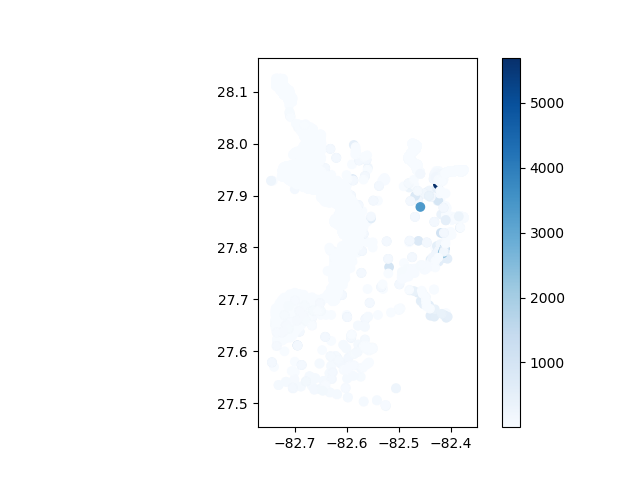

In [33]:
result_counts = clean_gdf.set_index(loc_ID).groupby(level=0).count()
# Drop columns in both tables from result_counts
drop_cols = [col for col in result_counts.columns if col in stations_aoi_gdf.columns]
result_counts.drop(columns=drop_cols, inplace=True)
result_counts = result_counts.join(stations_aoi_gdf.set_index(loc_ID))
result_counts.plot(column='deg_c', cmap='Blues', legend=True)

In [34]:
count_temp = result_counts['deg_c']
print('Range: {} to {} \n Mean: {}'.format(count_temp.min(),
                                           count_temp.max(),
                                           count_temp.mean()))

Range: 1 to 5698 
 Mean: 19.349889380530975


<IPython.core.display.Javascript object>


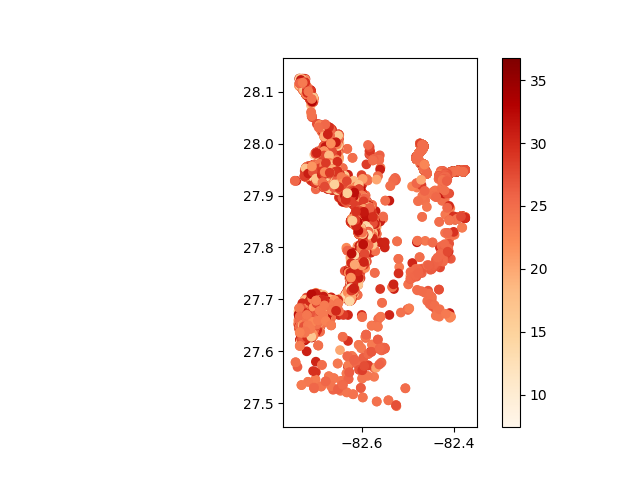

In [35]:
result_mean = clean_gdf.set_index(loc_ID).groupby(level=0).mean()
result_mean = stations_aoi_gdf.set_index(loc_ID).join(result_mean)
result_mean.plot(column='deg_c', cmap='OrRd', legend=True)

In [36]:
mean_temp = result_mean['deg_c']
print('Range: {} to {}\n Mean: {}'.format(mean_temp.min(),
                                          mean_temp.max(),
                                          mean_temp.mean()))

Range: 7.409999847412109 to 36.78999900817871
 Mean: 25.08637742027256
